In [2]:
from pathlib import Path
import pandas as pd

# Load the combined_threshold_dataset.csv into a pandas DataFrame

DATASET_PATH = Path("/home/ubuntu/practical_deflection/Omnet_Sims/dc_simulations/simulations/sims/combined_threshold_dataset.csv")

if not DATASET_PATH.exists():
    raise FileNotFoundError(f"Dataset not found: {DATASET_PATH}")

combined_threshold_df = pd.read_csv(DATASET_PATH, low_memory=False)

print(f"Loaded {len(combined_threshold_df):,} rows and {combined_threshold_df.shape[1]} columns from {DATASET_PATH.name}")
try:
    display(combined_threshold_df.head())
except Exception:
    print(combined_threshold_df.head().to_string(index=False))

Loaded 3,073,457 rows and 19 columns from combined_threshold_dataset.csv


,timestamp,deflection_threshold,RequesterID,seq_num,packet_position,flow_start_time,flow_end_time,FCT,action,capacity,total_capacity,occupancy,total_occupancy,ttl,packet_size,SWITCH_ID,ooo,start_time,end_time
0,0.000246,0.3,10829.0,3479085149,1,0.000345,0.058154,0.057809,0,400000,17600000,0,0,249,32,agg2,0,0.000242,0.000265
1,0.000254,0.3,10829.0,3479085149,2,0.000345,0.058154,0.057809,0,400000,3200000,0,0,248,32,spine0,0,0.000242,0.000265
2,0.000255,0.3,10199.0,960733508,1,0.000304,0.002092,0.001788,0,400000,17600000,0,0,249,32,agg4,0,0.000250,0.000258
3,0.000255,0.3,10199.0,960733508,2,0.000304,0.002092,0.001788,0,400000,17600000,0,0,249,32,agg0,0,0.000250,0.000258
4,0.000255,0.3,101796.0,960733508,1,0.000290,0.000290,0.000000,0,400000,17600000,0,0,249,32,agg4,0,0.000250,0.000258


In [3]:
# Create a DataFrame for each deflection_threshold value
dfs_by_threshold = {thr: grp for thr, grp in combined_threshold_df.groupby('deflection_threshold', sort=True)}
print(f"Created {len(dfs_by_threshold)} dataframes keyed by deflection_threshold in dfs_by_threshold")

Created 4 dataframes keyed by deflection_threshold in dfs_by_threshold


In [4]:
# Derive one FCT per unique flow (RequesterID) for each deflection_threshold
# Use the row with the latest end_time per (threshold, RequesterID) to represent the flow
_flow_cols = ['deflection_threshold', 'RequesterID', 'FCT', 'flow_end_time']
flows_nonnull = combined_threshold_df.loc[combined_threshold_df['FCT'].notna(), _flow_cols]

# Pick the row with max flow_end_time per (threshold, RequesterID)
idx = flows_nonnull.groupby(['deflection_threshold', 'RequesterID'])['flow_end_time'].idxmax()
per_flow = flows_nonnull.loc[idx, ['deflection_threshold', 'RequesterID', 'FCT']].reset_index(drop=True)

# Retrieve unique flows per threshold
unique_flows_by_threshold = {
    thr: grp['RequesterID'].unique()
    for thr, grp in per_flow.groupby('deflection_threshold', sort=True)
}

# Compute mean and 95th percentile of per-flow FCT (ms) per threshold
per_flow_fct_stats = (
    per_flow
    .groupby('deflection_threshold', sort=True)
    .agg(
        n_flows=('RequesterID', 'nunique'),
        mean_fct_ms=('FCT', lambda s: s.mean() * 1e3),
        p95_fct_ms=('FCT', lambda s: s.quantile(0.95) * 1e3),
    )
    .reset_index()
)

# Convenience lists aligned by threshold
flow_thr_values = per_flow_fct_stats['deflection_threshold'].tolist()
mean_flow_fct_ms = per_flow_fct_stats['mean_fct_ms'].tolist()
p95_flow_fct_ms = per_flow_fct_stats['p95_fct_ms'].tolist()

print(f"Computed per-flow stats for {len(flow_thr_values)} thresholds from {len(per_flow)} unique flows.")
for thr, ids in unique_flows_by_threshold.items():
    print(f"  threshold {thr}: {ids.size} unique flows")

try:
    display(per_flow_fct_stats)
except Exception:
    print(per_flow_fct_stats.to_string(index=False))

Computed per-flow stats for 4 thresholds from 18918 unique flows.
  threshold 0.3: 3770 unique flows
  threshold 0.5: 4466 unique flows
  threshold 0.75: 5088 unique flows
  threshold 1.0: 5594 unique flows


,deflection_threshold,n_flows,mean_fct_ms,p95_fct_ms
0,0.30,3770,18.706175,50.915683
1,0.50,4466,17.482606,44.557360
2,0.75,5088,16.556950,41.437543
3,1.00,5594,16.108027,41.265268


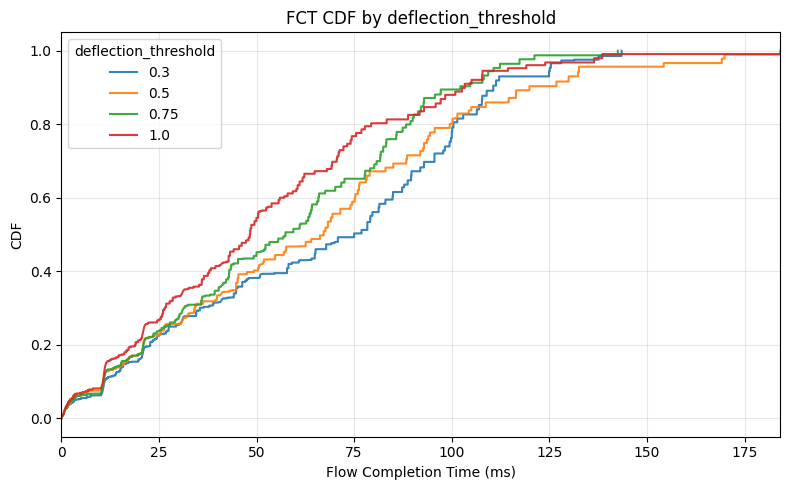

In [5]:
import numpy as np

import matplotlib.pyplot as plt

# Plot ECDFs of FCT for each deflection_threshold
fig, ax = plt.subplots(figsize=(8, 5))
xmax_p99 = []

for thr in sorted(dfs_by_threshold):
    fct = dfs_by_threshold[thr]['FCT'].dropna().to_numpy()
    if fct.size == 0:
        continue
    x_ms = np.sort(fct) * 1e3  # convert to ms
    y = np.arange(1, x_ms.size + 1) / x_ms.size
    ax.step(x_ms, y, where='post', label=str(thr), alpha=0.9)
    xmax_p99.append(np.percentile(x_ms, 99))

# Improve readability by limiting to the common 99th percentile
if xmax_p99:
    ax.set_xlim(0, max(xmax_p99))

ax.set_xlabel('Flow Completion Time (ms)')
ax.set_ylabel('CDF')
ax.set_title('FCT CDF by deflection_threshold')
ax.grid(True, alpha=0.3)
ax.legend(title='deflection_threshold')
plt.tight_layout()

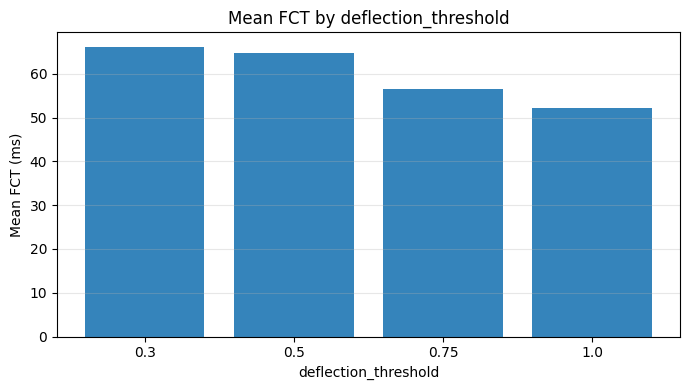

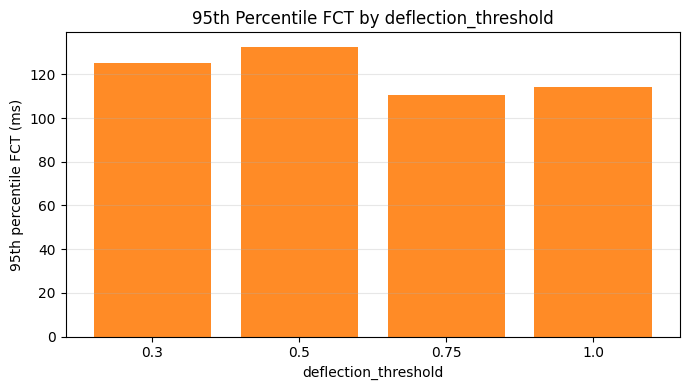

In [6]:
# Compute mean and 95th percentile FCT (in ms) per deflection_threshold
thr_values = []
mean_fct_ms = []
p95_fct_ms = []

for thr_key in sorted(dfs_by_threshold):
    fct_s = dfs_by_threshold[thr_key]['FCT'].dropna().to_numpy()
    if fct_s.size == 0:
        continue
    thr_values.append(thr_key)
    mean_fct_ms.append(fct_s.mean() * 1e3)
    p95_fct_ms.append(np.percentile(fct_s, 95) * 1e3)

# Plot Mean FCT
fig_mean, ax_mean = plt.subplots(figsize=(7, 4))
ax_mean.bar([str(t) for t in thr_values], mean_fct_ms, alpha=0.9)
ax_mean.set_xlabel('deflection_threshold')
ax_mean.set_ylabel('Mean FCT (ms)')
ax_mean.set_title('Mean FCT by deflection_threshold')
ax_mean.grid(axis='y', alpha=0.3)
plt.tight_layout()

# Plot 95th percentile FCT
fig_p95, ax_p95 = plt.subplots(figsize=(7, 4))
ax_p95.bar([str(t) for t in thr_values], p95_fct_ms, color='tab:orange', alpha=0.9)
ax_p95.set_xlabel('deflection_threshold')
ax_p95.set_ylabel('95th percentile FCT (ms)')
ax_p95.set_title('95th Percentile FCT by deflection_threshold')
ax_p95.grid(axis='y', alpha=0.3)
plt.tight_layout()

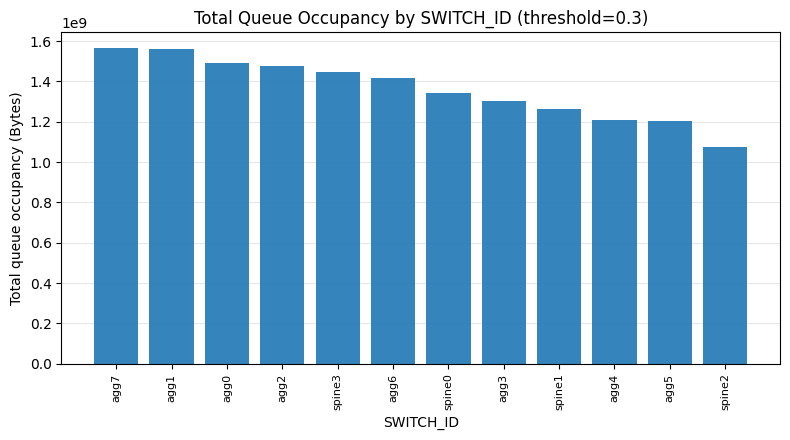

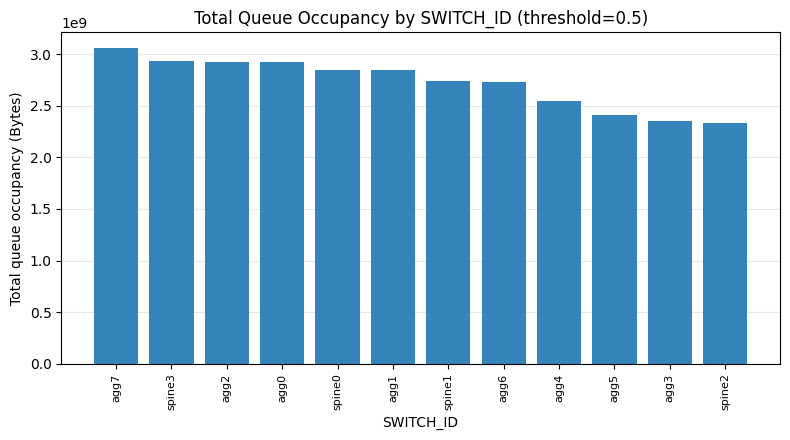

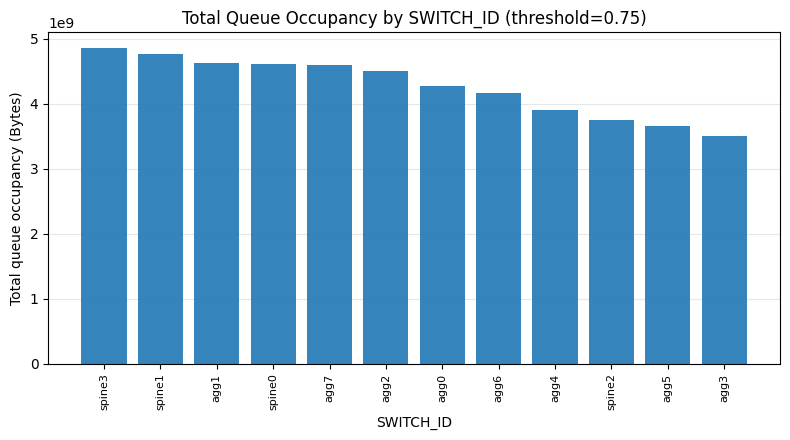

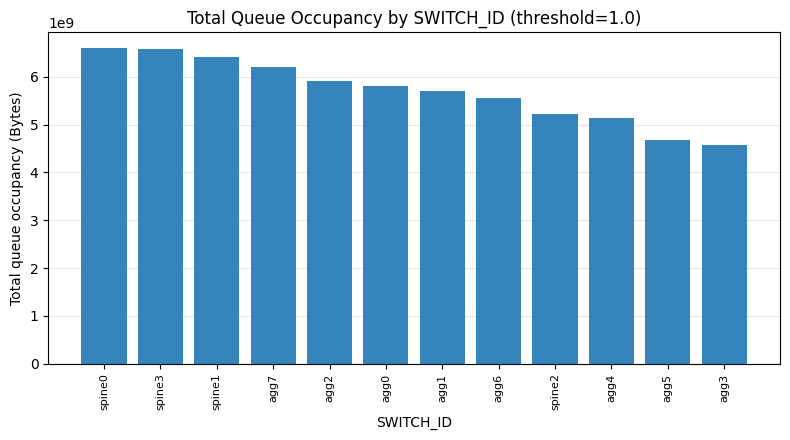

In [7]:
# Total queue occupancy per SWITCH_ID for each deflection_threshold, plotted separately
# Uses dfs_by_threshold from earlier cells.

totals_by_threshold = {}

for thr in sorted(dfs_by_threshold):
    df_thr = dfs_by_threshold[thr]
    # Sum occupancy over time per switch
    totals = (
        df_thr.groupby('SWITCH_ID', sort=False)['total_occupancy']
        .sum()
        .sort_values(ascending=False)
    )
    totals_by_threshold[thr] = totals

    # Plot comparison between SWITCH_IDs for this threshold
    fig_thr, ax_thr = plt.subplots(figsize=(max(8, 0.25 * len(totals)), 4.5))
    ax_thr.bar(totals.index, totals.values, alpha=0.9)
    ax_thr.set_title(f"Total Queue Occupancy by SWITCH_ID (threshold={thr})")
    ax_thr.set_xlabel("SWITCH_ID")
    ax_thr.set_ylabel("Total queue occupancy (Bytes)")
    ax_thr.grid(axis='y', alpha=0.3)
    ax_thr.set_axisbelow(True)
    for tick in ax_thr.get_xticklabels():
        tick.set_rotation(90)
        tick.set_fontsize(8)
    plt.tight_layout()

,deflection_threshold,total_unique_flows,completed_unique_flows,completion_rate_pct
0,0.30,9783,3770,38.536236
1,0.50,9822,4466,45.469355
2,0.75,9892,5088,51.435503
3,1.00,9895,5594,56.533603


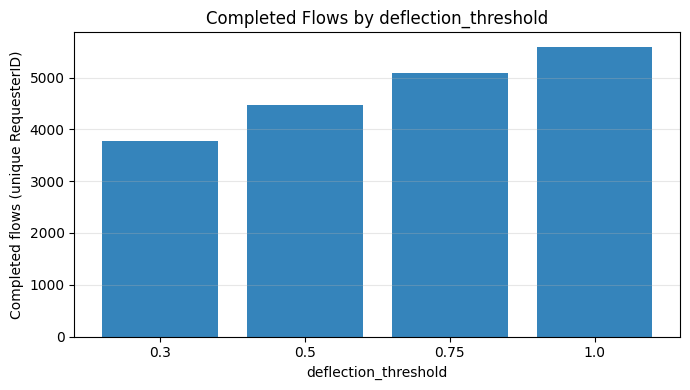

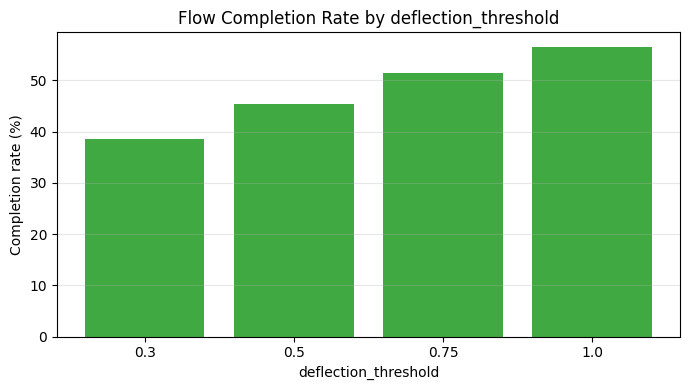

In [8]:
# Compute and plot flow completion counts and rates per deflection_threshold
# A flow is considered completed if it has any non-null FCT.

# Total unique flows per threshold (denominator)
total_flows_by_thr = (
    combined_threshold_df.groupby('deflection_threshold')['RequesterID']
    .nunique()
)

# Completed unique flows per threshold (numerator)
completed_flows_by_thr = (
    flows_nonnull.groupby('deflection_threshold')['RequesterID']
    .nunique()
)

# Ensure consistent threshold ordering
thr_order = sorted(combined_threshold_df['deflection_threshold'].unique())
total_flows_by_thr = total_flows_by_thr.reindex(thr_order, fill_value=0)
completed_flows_by_thr = completed_flows_by_thr.reindex(thr_order, fill_value=0)

# Completion rate (%)
completion_rate_pct = (completed_flows_by_thr / total_flows_by_thr.replace(0, pd.NA)) * 100

# Summary table
completion_summary = pd.DataFrame({
    'deflection_threshold': thr_order,
    'total_unique_flows': total_flows_by_thr.values,
    'completed_unique_flows': completed_flows_by_thr.values,
    'completion_rate_pct': completion_rate_pct.values
})

try:
    display(completion_summary)
except Exception:
    print(completion_summary.to_string(index=False))

# Plot number of completed flows
fig_completed, ax_completed = plt.subplots(figsize=(7, 4))
ax_completed.bar([str(t) for t in thr_order], completed_flows_by_thr.values, alpha=0.9)
ax_completed.set_xlabel('deflection_threshold')
ax_completed.set_ylabel('Completed flows (unique RequesterID)')
ax_completed.set_title('Completed Flows by deflection_threshold')
ax_completed.grid(axis='y', alpha=0.3)
plt.tight_layout()

# Plot completion rate (%)
fig_rate, ax_rate = plt.subplots(figsize=(7, 4))
ax_rate.bar([str(t) for t in thr_order], completion_rate_pct.fillna(0).values, color='tab:green', alpha=0.9)
ax_rate.set_xlabel('deflection_threshold')
ax_rate.set_ylabel('Completion rate (%)')
ax_rate.set_title('Flow Completion Rate by deflection_threshold')
ax_rate.grid(axis='y', alpha=0.3)
plt.tight_layout()

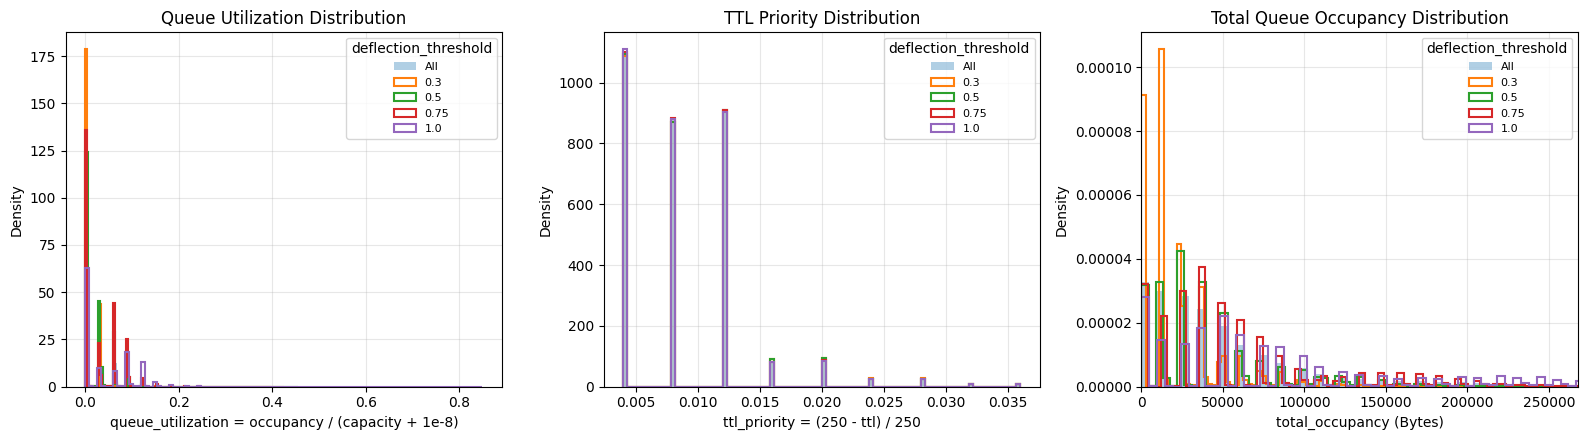

In [9]:
# Feature distributions: queue_utilization, ttl_priority, and total_occupancy
# Uses combined_threshold_df and dfs_by_threshold defined earlier.

# Compute features for the full dataset
queue_util_all = combined_threshold_df['occupancy'] / (combined_threshold_df['capacity'] + 1e-8)
ttl_priority_all = (250 - combined_threshold_df['ttl']) / 250.0
total_occupancy_all = combined_threshold_df['total_occupancy']

# Percentile-based x-limits to improve readability
p99_total_occ = total_occupancy_all.quantile(0.99)

fig, axes = plt.subplots(1, 3, figsize=(16, 4.5))

# Queue Utilization
axes[0].hist(queue_util_all.dropna(), bins=100, density=True, alpha=0.35, label='All')
for thr, df_thr in sorted(dfs_by_threshold.items()):
    q_thr = (df_thr['occupancy'] / (df_thr['capacity'] + 1e-8)).dropna()
    if not q_thr.empty:
        axes[0].hist(q_thr, bins=100, density=True, histtype='step', linewidth=1.5, label=str(thr))
axes[0].set_title('Queue Utilization Distribution')
axes[0].set_xlabel('queue_utilization = occupancy / (capacity + 1e-8)')
axes[0].set_ylabel('Density')
axes[0].grid(True, alpha=0.3)
axes[0].legend(title='deflection_threshold', fontsize=8)

# TTL Priority
axes[1].hist(ttl_priority_all.dropna(), bins=100, density=True, alpha=0.35, label='All')
for thr, df_thr in sorted(dfs_by_threshold.items()):
    ttl_thr = ((250 - df_thr['ttl']) / 250.0).dropna()
    if not ttl_thr.empty:
        axes[1].hist(ttl_thr, bins=100, density=True, histtype='step', linewidth=1.5, label=str(thr))
axes[1].set_title('TTL Priority Distribution')
axes[1].set_xlabel('ttl_priority = (250 - ttl) / 250')
axes[1].set_ylabel('Density')
axes[1].grid(True, alpha=0.3)
axes[1].legend(title='deflection_threshold', fontsize=8)

# Total Occupancy (Bytes)
axes[2].hist(total_occupancy_all.dropna(), bins=100, density=True, alpha=0.35, label='All')
for thr, df_thr in sorted(dfs_by_threshold.items()):
    occ_thr = df_thr['total_occupancy'].dropna()
    if not occ_thr.empty:
        axes[2].hist(occ_thr, bins=100, density=True, histtype='step', linewidth=1.5, label=str(thr))
if pd.notna(p99_total_occ):
    axes[2].set_xlim(0, p99_total_occ)  # focus on bulk of distribution
axes[2].set_title('Total Queue Occupancy Distribution')
axes[2].set_xlabel('total_occupancy (Bytes)')
axes[2].set_ylabel('Density')
axes[2].grid(True, alpha=0.3)
axes[2].legend(title='deflection_threshold', fontsize=8)

plt.tight_layout()

In [10]:
# Analyze the immediate impact of each deflection decision
# Compare packets that were deflected vs those that weren't

# Separate deflected vs non-deflected packets
deflected_packets = combined_threshold_df[combined_threshold_df['action'] == 1]
forwarded_packets = combined_threshold_df[combined_threshold_df['action'] == 0]

print(f"Deflected packets: {len(deflected_packets):,}")
print(f"Forwarded packets: {len(forwarded_packets):,}")

# Compare packet-level metrics
# Compute packet_delay (seconds) for each row
combined_threshold_df['packet_delay'] = combined_threshold_df['end_time'] - combined_threshold_df['start_time']

# Masks for deflected vs forwarded
_mask_def = combined_threshold_df['action'] == 1
_mask_fwd = combined_threshold_df['action'] == 0

packet_analysis = pd.DataFrame({
    'metric': ['packet_delay_ms', 'queue_utilization', 'total_occupancy'],
    'deflected_mean': [
        combined_threshold_df.loc[_mask_def, 'packet_delay'].mean() * 1e3,
        (combined_threshold_df.loc[_mask_def, 'occupancy'] / (combined_threshold_df.loc[_mask_def, 'capacity'] + 1e-8)).mean(),
        combined_threshold_df.loc[_mask_def, 'total_occupancy'].mean()
    ],
    'forwarded_mean': [
        combined_threshold_df.loc[_mask_fwd, 'packet_delay'].mean() * 1e3,
        (combined_threshold_df.loc[_mask_fwd, 'occupancy'] / (combined_threshold_df.loc[_mask_fwd, 'capacity'] + 1e-8)).mean(),
        combined_threshold_df.loc[_mask_fwd, 'total_occupancy'].mean()
    ]
})
packet_analysis['deflection_benefit'] = packet_analysis['forwarded_mean'] - packet_analysis['deflected_mean']
packet_analysis['benefit_pct'] = (packet_analysis['deflection_benefit'] / packet_analysis['forwarded_mean']) * 100

display(packet_analysis)

Deflected packets: 238,963
Forwarded packets: 2,834,494


,metric,deflected_mean,forwarded_mean,deflection_benefit,benefit_pct
0,packet_delay_ms,0.324088,0.286014,-0.038074,-13.311913
1,queue_utilization,0.084341,0.021280,-0.063061,-296.341719
2,total_occupancy,101004.793545,50976.424143,-50028.369402,-98.140209


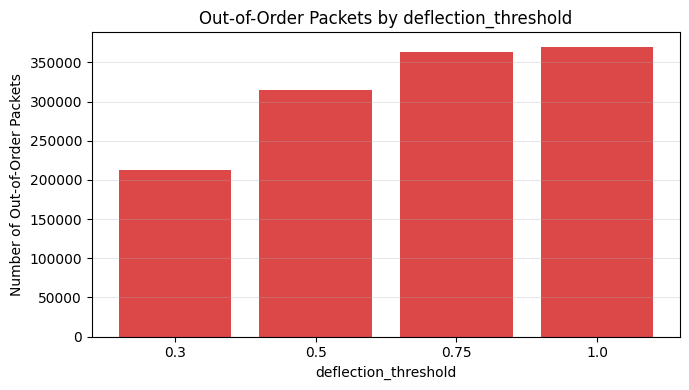

In [11]:
# Plot the number of out-of-order (ooo) packets across different deflection_thresholds

# Count ooo packets per threshold
ooo_counts_by_thr = (
    combined_threshold_df.groupby('deflection_threshold')['ooo']
    .sum()
    .reindex(sorted(dfs_by_threshold.keys()), fill_value=0)
)

fig_ooo, ax_ooo = plt.subplots(figsize=(7, 4))
ax_ooo.bar([str(t) for t in ooo_counts_by_thr.index], ooo_counts_by_thr.values, color='tab:red', alpha=0.85)
ax_ooo.set_xlabel('deflection_threshold')
ax_ooo.set_ylabel('Number of Out-of-Order Packets')
ax_ooo.set_title('Out-of-Order Packets by deflection_threshold')
ax_ooo.grid(axis='y', alpha=0.3)
plt.tight_layout()

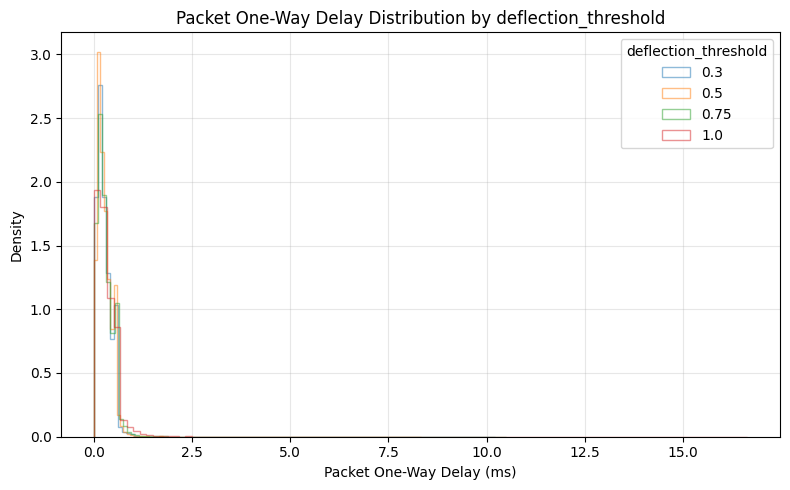

In [12]:
# Plot the packet one-way delay (end_time - start_time) distribution for each deflection_threshold

fig_delay, ax_delay = plt.subplots(figsize=(8, 5))

for thr in sorted(dfs_by_threshold):
    df_thr = dfs_by_threshold[thr]
    delays = (df_thr['end_time'] - df_thr['start_time']).dropna() * 1e3  # convert to ms
    if delays.empty:
        continue
    ax_delay.hist(delays, bins=100, density=True, alpha=0.5, label=str(thr), histtype='step')

ax_delay.set_xlabel('Packet One-Way Delay (ms)')
ax_delay.set_ylabel('Density')
ax_delay.set_title('Packet One-Way Delay Distribution by deflection_threshold')
ax_delay.grid(True, alpha=0.3)
ax_delay.legend(title='deflection_threshold')
plt.tight_layout()